# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project. To run the training you must:

1. Follow the instructions in **Readme.md** to install prerequisites.
2. Rename the **file_name** variable in the code in section 3.1 to reflect your Unity environment.

### 1. Import necessary packages
To get started, run the following cell to import the packages necessary for this training.

In [1]:
from unityagents import UnityEnvironment
from matplotlib import pyplot as plt
import numpy as np
import collections
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

### 2. Implement a Deep Deterministic Policy Gradient (DDPG) agent
You can use a Deep Deterministic Policy Gradient (DDPG) algorithm to train both agents for this task. DDPG agents are actor-critic agents with deterministic policies. For more information on DDPG agents see the SpinningUp blog here.

The major pieces in a DDPG agent are a deterministic actor (or policy), a critic that outputs the Q-Value function Q(s,a), a buffer that stores experiences in offline fashion, and a noise model that aids in exploration (we will use OU noise). In the following sections, we will implement each of these pieces.

### 2.1 Deterministic actor

To model a deterministic actor, we use a neural network with two hidden layers of size 256 and 128. The inputs to the neural network are the **local observations** of each agent (24) and the outputs are the **local actions** (2). A **tanh layer** wraps the final layer to ensure that the output remains within the bounds -1 and 1.

In [2]:
class DeterministicActor(nn.Module):
    
    def __init__(self, num_obs, num_act, seed=0):
        """ Initialize network. """
        
        torch.manual_seed(seed)

        super(DeterministicActor, self).__init__()

        self.num_obs = num_obs
        self.num_act = num_act
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        # layers
        self.fc1 = nn.Linear(num_obs,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,num_act)
        self.tanh = nn.Tanh()
        self.reset_parameters()
        
    def reset_parameters(self):
        """ Reset network weights. """
        
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """ Perform forward pass through the network. """
        
        # convert to torch
        if isinstance(state, np.ndarray):
            x = torch.from_numpy(state).float().to(self.device)
        elif isinstance(state, torch.Tensor) or isinstance(state, torch.cuda.FloatTensor):
            x = state
        else:
            raise TypeError("Input must be a numpy array or torch Tensor.")
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))  # restrict action from -1 to 1 using tanh
        return x
    
    def mu(self, state):
        """ Get actions from the deterministic policy. """
        
        return self.forward(state)
    
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

### 2.2 Critic
The critic in a DDPG agent takes states as inputs and outputs the state-action value Q(s,a). We use a similar neural network structure as the actor to model the critic, with one difference of the output size being 1.

In [3]:
class QCritic(nn.Module):

    def __init__(self, num_obs, num_act, seed=0):
        """ Initialize a Q-value critic network. """

        super(QCritic, self).__init__()

        torch.manual_seed(seed)
        self.num_obs = num_obs

        # ------ layers ------
        
        # state path
        self.sfc1 = nn.Linear(num_obs,256)
        self.cfc1 = nn.Linear(256+num_act,128)
        self.cfc2 = nn.Linear(128,1)
        self.reset_parameters()

    def reset_parameters(self): 
        """ Reset network weights """
        
        self.sfc1.weight.data.uniform_(*hidden_init(self.sfc1))
        self.cfc1.weight.data.uniform_(*hidden_init(self.cfc1))
        self.cfc2.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """ Perform forward pass through the network. """
        
        # convert to torch
        if isinstance(state, np.ndarray):
            s = torch.from_numpy(state).float().to(self.device)
        elif isinstance(state, torch.Tensor) or isinstance(state, torch.cuda.FloatTensor):
            s = state
        else:
            raise TypeError("Input must be a numpy array or torch Tensor.")
            
        if isinstance(action, np.ndarray):
            a = torch.from_numpy(action).float().to(self.device)
        elif isinstance(action, torch.Tensor):
            a = action
        else:
            raise TypeError("Input must be a numpy array or torch Tensor.")

        xs = F.relu(self.sfc1(s))
        xc = torch.cat((xs,a), dim=1)
        xc = F.relu(self.cfc1(xc))
        xc = self.cfc2(xc)

        return xc


    def Q(self, state, action):
        """ Compute Q(s,a) """
        
        return self.forward(state, action)

### 2.3 Experience Buffer
An experience buffer stores the agent's experiences as it interacts with the environment. The experiences are states, actions, rewards, next states and done values. In this notebook, the terms experience buffer and replay memory are used interchangably.

In [4]:
class ExperienceBuffer:
    
    def __init__(self, state_dim, act_dim, max_len=1e6):
        """ Initialize a replay memory for storing experiences. """
        self.state_dim = state_dim
        self.act_dim = act_dim
        self.max_len = max_len
        
        # elements in the buffer will be stacked on top of another
        self.states = np.empty((self.max_len,self.state_dim))
        self.actions = np.empty((self.max_len,self.act_dim))
        self.rewards = np.empty((self.max_len,1))
        self.next_states = np.empty((self.max_len,self.state_dim))
        self.dones = np.empty((self.max_len,1))
        
        self.last_idx = -1
        
        
    def add(self, state, action, reward, next_state, done):
        """ Add experiences to replay memory. """
           
        self.last_idx += 1
        if self.last_idx >= self.max_len:
            self.last_idx = 0
        
        self.states[self.last_idx] = state
        self.actions[self.last_idx] = action
        self.rewards[self.last_idx] = reward
        self.next_states[self.last_idx] = next_state
        self.dones[self.last_idx] = done
        
        
    def sample(self, batch_size, device='cpu'):
        """ Get randomly sampled experiences. """
        
        # random indices
        batch_idxs = np.random.choice(self.last_idx+1, batch_size)
        
        # convert to tensors
        states_batch = torch.from_numpy(self.states[batch_idxs]).float().to(device)
        actions_batch = torch.from_numpy(self.actions[batch_idxs]).float().to(device)
        rewards_batch = torch.from_numpy(self.rewards[batch_idxs]).float().to(device)
        next_states_batch = torch.from_numpy(self.next_states[batch_idxs]).float().to(device)
        dones_batch = torch.from_numpy(self.dones[batch_idxs]).float().to(device)
        
        return states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch


    def __len__(self):
        """ Return the current size of internal memory. """
        
        return self.last_idx + 1

### 2.4 OU Noise model
To boost exploration during training, we model the action noise based on Ornstein-Uhlenbeck action noise. The key parts of the noise are the mean attraction constant, variance, and decay rate. Tuning the noise properties has a big impact on the training.

In [5]:
class OUNoise:
    
    def __init__(self, size, mean=0, mac=0.15, var=0.1, varmin=0.01, decay=1e-6):
        """ 
        Initialize Ornstein-Uhlenbech action noise. 
        
        """
        self.size = size
        self.mean = mean * np.ones(size)
        self.mac = mac
        self.var = var
        self.varmin = varmin
        self.decay = decay
        self.x = np.zeros(size)
        self.xprev = self.x
        self.step_count = 0
        
    def step(self):
        """ 
        Step the OU noise model by computing the noise and decaying variance. 
        
        """
        self.x = self.xprev + self.mac * (self.mean - self.xprev) + self.var * np.random.randn(self.size)
        self.xprev = self.x
        dvar = self.var * (1-self.decay)
        self.var = np.maximum(dvar, self.varmin)
        self.step_count += 1
        return self.x

### 2.5 DDPG algorithm
The following code cell combines the aboves pieces together and implements the DDPG algorithm.

In [6]:
class DDPGAgent:
    
    def __init__(self, actor, critic, target_actor, target_critic, buffer, params):
        """
        Initialize a Deep Deterministic Policy Gradient (DDPG) agent.
        
        """
        # parameters
        self.gamma = params["GAMMA"]
        self.batch_size = params["BATCH_SIZE"]
        self.tau = params["TAU"]
        self.actor_LR = params["ACTOR_LR"]
        self.critic_LR = params["CRITIC_LR"]
        self.update_freq = params["UPDATE_FREQ"]
        self.train_iters = params["TRAIN_ITERS"]
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.step_count = 0
        
        # initialize actor
        self.actor = actor
        self.target_actor = target_actor
        
        # initialize critic
        self.critic = critic
        self.target_critic = target_critic
        
        # create optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.actor_LR)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.critic_LR)
        
        # Experience replay
        self.buffer = buffer
        
        # Noise model
        self.noise_model = OUNoise(size=params["NOISE_SIZE"], mean=params["NOISE_MEAN"], 
                                   mac=params["NOISE_MAC"], var=params["NOISE_VAR"], 
                                   varmin=params["NOISE_VARMIN"], decay=params["NOISE_DECAY"])
        
        # initialize logs
        self.actor_loss_log = [0]
        self.critic_loss_log = [0]
        self.noise_log = [0]
        
    
    def get_action(self, state, train=False):
        """
        Get the action by sampling from the policy. If train is set to True 
        then the action contains added noise.
        
        """
        
        with torch.no_grad():
            action = self.actor.mu(state).cpu().numpy()
            
        # If in train mode then add noise
        if train:
            noise = self.noise_model.step()
            action += noise
            self.noise_log.append(self.noise_model.var)
        
        # clip the action, just in case
        action = np.clip(action, -1, 1)
        
        return action
        
    
    def step(self, state, action, reward, next_state, done, train=True):
        """
        Step the agent, store experiences and learn.
            
        """
        
        # add experience to replay
        self.buffer.add(state, action, reward, next_state, done)
        
        # increase step count
        self.step_count += 1
        
        # learn from experiences
        if train and self.buffer.__len__() > self.batch_size:
            
            for _ in range(self.train_iters):
            
                # create mini batch for learning
                experiences = self.buffer.sample(self.batch_size, self.device)
                
                # train the agent
                self.learn(experiences)
    
    
    def learn(self, experiences):
        """
        Train the actor and critic.
        
        """
        
        # unpack experience
        states, actions, rewards, next_states, dones = experiences
        
        # compute td targets
        with torch.no_grad():
            target_action = self.target_actor.mu(next_states)
            targetQ = self.target_critic.Q(next_states,target_action)
            y = rewards + self.gamma * targetQ * (1-dones)
        
        # compute local Q values
        Q = self.critic.Q(states, actions)
        
        # critic loss
        critic_loss = F.mse_loss(Q,y)

        # update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)  # gradient clipping
        self.critic_optimizer.step()
        
        # freeze critic before policy loss computation
        for p in self.critic.parameters():
            p.requires_grad = False
        
        # actor loss
        actor_loss = -self.critic.Q(states, self.actor.mu(states)).mean()
        
        # update actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1)  # gradient clipping
        self.actor_optimizer.step()
        
        # Unfreeze critic
        for p in self.critic.parameters():
            p.requires_grad = True
            
        # log the loss and noise
        self.actor_loss_log.append(actor_loss.detach().cpu().numpy())
        self.critic_loss_log.append(critic_loss.detach().cpu().numpy())
        #self.noise_log.append(np.mean(self.noise_model.x))
        
        # soft update target actor and critic
        if self.step_count % self.update_freq == 0:
            self.soft_update(self.target_actor, self.actor)
            self.soft_update(self.target_critic, self.critic)
            
    
    def soft_update(self, target_model, model):
        """
        Soft update target networks.
        """
        with torch.no_grad():
            for target_params, params in zip(target_model.parameters(), model.parameters()):
                target_params.data.copy_(self.tau*params + (1-self.tau)*target_params.data)
    


### 3. Training the agents

In this multi-agent training task, each agent must learn how to strike the ball such that it passes over the net. Our approach is to treat this as a self-play task, with the agents sharing information and learning from each other's experiences. The agents have their own local observations and actions, but share the actors, critics and the experience buffer.

### 3.1 Train loop
Run the following code cell to start the training. Make sure you change the environment as per your platform by providing a path to the **file_name** variable.

In [7]:
# DDPG hyperparameters
params = {
    "BUFFER_LENGTH": int(1e5),
    "BATCH_SIZE": 128,
    "GAMMA": 0.995,
    "ACTOR_LR": 1e-4,
    "CRITIC_LR": 2e-4,
    "TAU": 0.05,
    "UPDATE_FREQ": 2,
    "TRAIN_ITERS": 10,
    "NOISE_SIZE": 2,
    "NOISE_MEAN": 0,
    "NOISE_MAC": 0.13,
    "NOISE_VAR": 0.2,
    "NOISE_VARMIN": 0.001,
    "NOISE_DECAY": 1e-5,
    }

# training options
MAX_EPISODES = 800      # Maximum number of training episodes
AVG_WINDOW = 100         # Window length for calculating score averages
TRAIN_EVERY = 5          # Episode interval for training
PRINT_EVERY = 50
VERBOSE = True
solved = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# observation and action specs of each agent
osize = 24
asize = 2
num_agents = 2

# score logs
reward_log = []
avg_log = []
avg_window = collections.deque(maxlen=AVG_WINDOW)

# ----- Setup -----

# create environment
# *** REPLACE file_name value with the environment you are using ***
env = UnityEnvironment(file_name='tennis.app')  

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# create experience buffer
buffer = ExperienceBuffer(osize, asize, max_len=params["BUFFER_LENGTH"])

# create noise models
np.random.seed(0)   # set the numpy seed

# create actor network
actor = DeterministicActor(osize, asize, seed=0).to(device)
target_actor = DeterministicActor(osize, asize, seed=0).to(device)

# create critic network
critic = QCritic(osize, asize, seed=0).to(device)
target_critic = QCritic(osize, asize, seed=0).to(device)


# create DDPG agents
agent_0 = DDPGAgent(actor, critic, target_actor, target_critic, buffer, params)
agent_1 = DDPGAgent(actor, critic, target_actor, target_critic, buffer, params)

# ------  Train loop -------

for ep_count in range(1,MAX_EPISODES):

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    
    ep_reward = np.zeros(num_agents)
    ep_steps = 1
    
    while True:
        
        # sample action from the current policy
        act_0 = agent_0.get_action(states[0], train=True)
        act_1 = agent_1.get_action(states[1], train=True)
        actions = np.concatenate((act_0, act_1), axis=0)
        actions = np.reshape(actions,(1,4))
        
        # step the environment
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = np.array(env_info.rewards)
        dones = np.array([1 if d is True else 0 for d in env_info.local_done])
        
        # step the agents
        dotrain = True if ep_count%TRAIN_EVERY==0 else False
        agent_0.step(states[0],act_0,rewards[0],next_states[0],dones[0],dotrain)
        agent_1.step(states[1],act_1,rewards[1],next_states[1],dones[1],dotrain)
        
        states = next_states
        ep_reward += rewards
        ep_steps += 1
        
        # terminate if done
        if np.any(dones):
            break
    
    # print training progress
    avg_window.append(np.max(ep_reward))
    avg_reward = np.mean(avg_window)
    avg_log.append(avg_reward)
    reward_log.append(ep_reward)
    if VERBOSE and (ep_count==1 or ep_count%PRINT_EVERY==0):
        print('Episode: {:4d} | Steps: {:4d} | Average Reward: {:.4f}'.format(ep_count,ep_steps,avg_reward))
        
    # check if env is solved
    if not solved and avg_reward >= 0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Reward: {:.4f}'.format(ep_count, avg_reward))
        solved = True

# save the actor
torch.save(actor.state_dict(), 'checkpoint_actor.pth')

# Close environment
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Episode:    1 | Steps:   16 | Average Reward: 0.0000
Episode:   50 | Steps:   16 | Average Reward: 0.0000
Episode:  100 | Steps:   15 | Average Reward: 0.0029
Episode:  150 | Steps:   31 | Average Reward: 0.0242
Episode:  200 | Steps:   31 | Average Reward: 0.0539
Episode:  250 | Steps:   98 | Average Reward: 0.0840
Episode:  300 | Steps:   54 | Average Reward: 0.1161
Episode:  350 | Steps:  166 | Average Reward: 0.1914
Episode:  400 | Steps:   31 | Average Reward: 0.2836
Episode:  450 | Steps:   31 | Average Reward: 0.3747

Environment solved in 480 episodes!	Average Reward: 0.5107
Episode:  500 | Steps:  469 | Average Reward: 0.6095
Episode:  550 | Steps:  603 | Average Reward: 0.8026
Episode:  600 | Steps:  320 | Average Reward: 0.7396
Episode:  650 | Steps:  371 | Average Reward: 0.5661
Episode:  700 | Steps:  494 | Average Reward: 0.4739
Episode:  750 | Steps:   31 | Average Reward: 0.6592


### 3.2 Plot results
Run the code cell below to plot the average reward and the actor and critic losses during training.

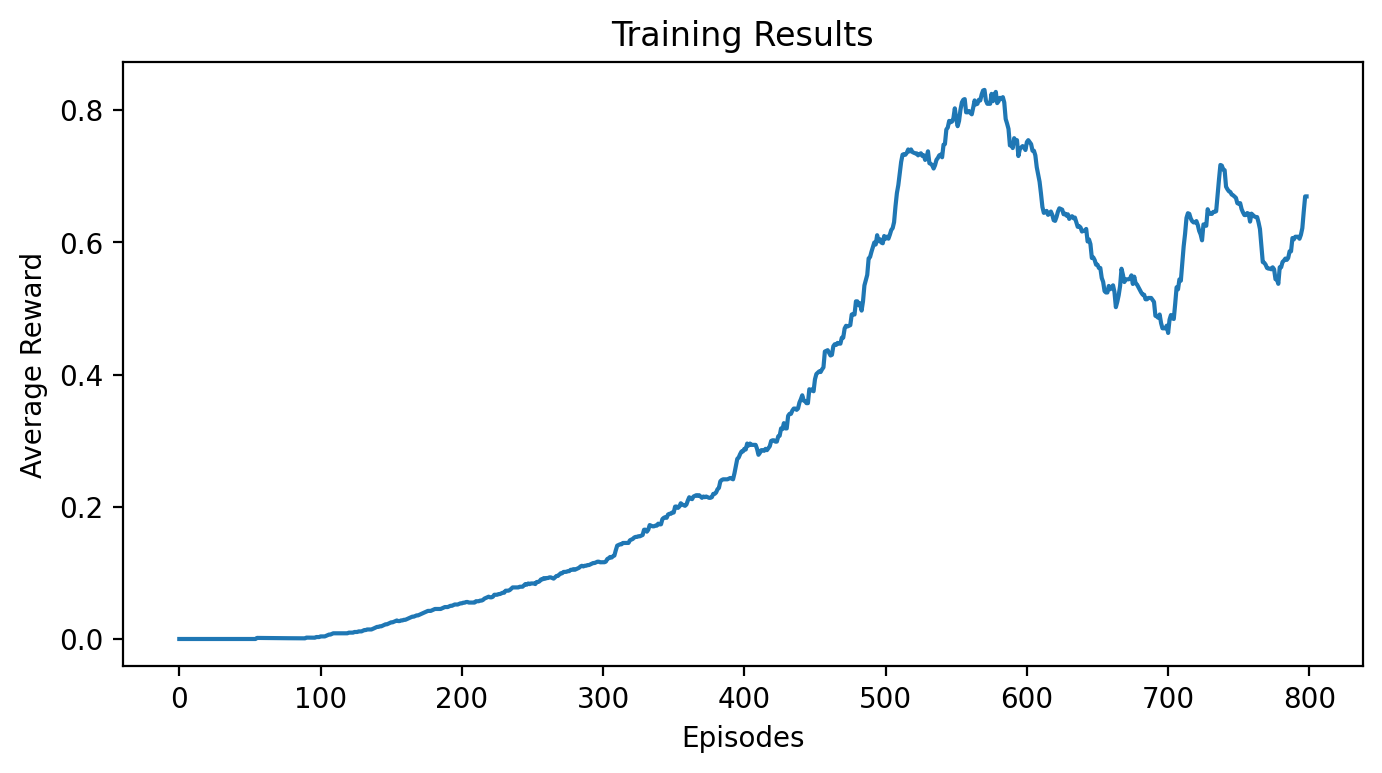

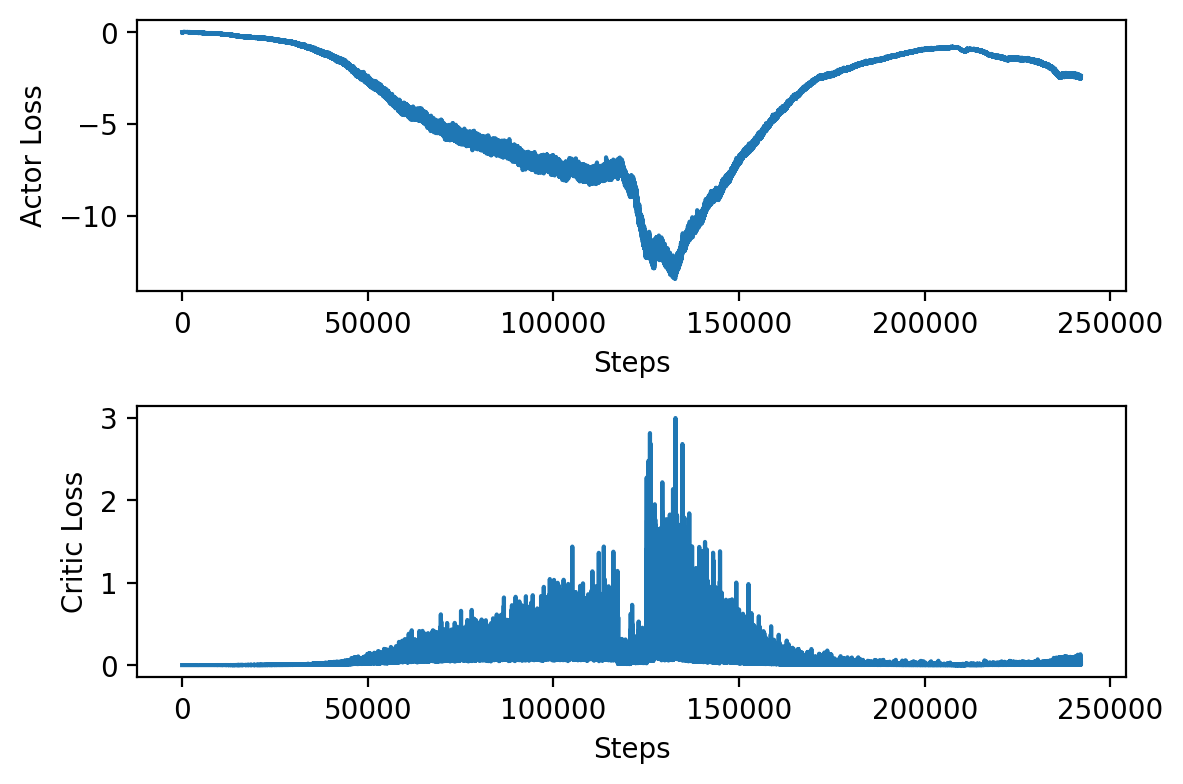

In [8]:
# plot score history
plt.ion()
fig1, ax1 = plt.subplots(1,1, figsize=(8,4), dpi=200)
ax1.set_title("Training Results")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Reward")
ax1.plot(avg_log)

fig2, axarr = plt.subplots(2,1, figsize=(6,4), dpi=200)
# plot loss
ax2 = axarr[0]
ax2.set_xlabel("Steps")
ax2.set_ylabel("Actor Loss")
ax2.plot(agent_0.actor_loss_log)

ax3 = axarr[1]
ax3.set_xlabel("Steps")
ax3.set_ylabel("Critic Loss")
ax3.plot(agent_0.critic_loss_log)

fig2.tight_layout(pad=1.0)
plt.show()